In [18]:
import api_nyt as nyt
import api_wikipedia as wiki
import manage_articles as mng
import statistics
import datetime
import pickle
import timeseries
import TextPreprocessing as txt
from datetime import date
import graphics
import matplotlib.pyplot as plt
import matching
import time
import word
import random
import numpy
from copy import deepcopy

In [2]:
#Load all articles from 2019 and a shuffled copy
articles_original = mng.load_articles("/Users/markus/Downloads/wikinewsPickle/nyt2019.json")
#articles = mng.shuffle_publicationdates(articles)

#Get a dict of dicts for each calendar week with word frequencies from getWordCounts
wordCounts_original = mng.getWordCounts(articles_original)

#List of distinct words 
distinctWords_original = mng.getDistinctWords(wordCounts_original)

#List of lists of tuples containing weekly word frequency
countsPerWeek_original = []
for w in distinctWords_original:
    countsPerWeek_original.append((w,mng.getCountPerWeek(wordCounts_original,w)))   

#Create list of word objects for each keyword
words_original = []
for c in countsPerWeek_original:
    words_original.append(word.Word(c[0],ts_articles=timeseries.Timeseries(c[1])))
#words = sorted(words, key=lambda x: sum(x.ts_articles.getCounts()), reverse=True)
with open("/Users/markus/Downloads/wikinewsPickle/articles_original.txt","wb") as fp:
    pickle.dump(articles_original,fp)
with open("/Users/markus/Downloads/wikinewsPickle/words_original.txt","wb") as fp:
    pickle.dump(words_original,fp)

In [3]:
#Load all articles from 2019 and a shuffled copy
articles_shuffled = mng.load_articles("/Users/markus/Downloads/wikinewsPickle/nyt2019.json")
articles_shuffled = mng.shuffle_publicationdates(articles_shuffled)

#Get a dict of dicts for each calendar week with word frequencies from getWordCounts
wordCounts_shuffled = mng.getWordCounts(articles_shuffled)

#List of distinct words 
distinctWords_shuffled = mng.getDistinctWords(wordCounts_shuffled)

#List of lists of tuples containing weekly word frequency
countsPerWeek_shuffled = []
for w in distinctWords_shuffled:
    countsPerWeek_shuffled.append((w,mng.getCountPerWeek(wordCounts_shuffled,w)))   

#Create list of word objects for each keyword
words_shuffled = []
for c in countsPerWeek_shuffled:
    words_shuffled.append(word.Word(c[0],ts_articles=timeseries.Timeseries(c[1])))
#words = sorted(words, key=lambda x: sum(x.ts_articles.getCounts()), reverse=True)
with open("/Users/markus/Downloads/wikinewsPickle/articles_shuffled.txt","wb") as fp:
    pickle.dump(articles_shuffled,fp)
with open("/Users/markus/Downloads/wikinewsPickle/words_shuffled.txt","wb") as fp:
    pickle.dump(words_shuffled,fp)

In [4]:
interestingWords_original = mng.filter_interestingness(articles_original, 10, 5)
interestingWords_shuffled = mng.filter_interestingness(articles_shuffled, 10, 5)

with open("/Users/markus/Downloads/wikinewsPickle/interestingWords_original.txt","wb") as fp:
    pickle.dump(interestingWords_original,fp)
with open("/Users/markus/Downloads/wikinewsPickle/interestingWords_shuffled.txt","wb") as fp:
    pickle.dump(interestingWords_shuffled,fp)
#For interesting words
keywords_original = []
for k in interestingWords_original:
    keywords_original.append(k)
keywords_shuffled = []
for k in interestingWords_shuffled:
    keywords_shuffled.append(k)

In [5]:
'''
w_original = [x for x in words_original if x.keyword == keywords_original[0]][0]
w_shuffled = [x for x in words_shuffled if x.keyword == w_original.keyword][0]
graphics.plot_dataset(w_original.keyword,w_original.ts_articles.getCounts(),w_original.ts_articles.getDates())
graphics.plot_dataset(w_shuffled.keyword,w_shuffled.ts_articles.getCounts(),w_original.ts_articles.getDates())
'''

614

In [20]:
m = matching.groupmatch(keywords_original, articles_original)
with open("/Users/markus/Downloads/wikinewsPickle/m.txt","wb") as fp:
    pickle.dump(m,fp)


In [25]:
start = time.process_time()
#For each returned entry from groupmatch, add wikipedia site and wiki timeseries to word object
for key in m.keys():
    #Following line from 
    #https://stackoverflow.com/questions/7125467/find-object-in-list-that-has-attribute-equal-to-some-value-that-meets-any-condi
    try:
        word = next((x for x in words_original if x.keyword == key), None)
        query = m[key]['query']
        page = m[key]['link'][1]
        wiki_counts = wiki.get_counts(page, word.ts_articles.getStartDate(), word.ts_articles.getEndDate(),"en")
        if wiki_counts is not None:
            #If wikipedia timeseries exists
            word.coocKeywords = query
            word.wikipediaSite = page
            word.ts_wiki = timeseries.parseWikipediaCounts(wiki_counts)
    except:
        print("ERROR: Key is invalid")
print(time.process_time() - start)

28.178765000000112


In [26]:
words_analyze_original = [x for x in words_original if x.wikipediaSite != ""]

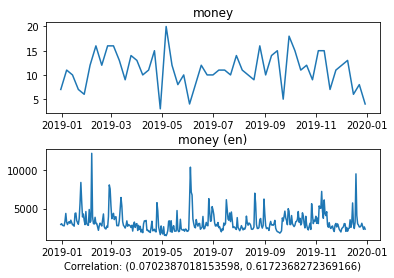

FileNotFoundError: [Errno 2] No such file or directory: './correlation_shuffled/money.png'

In [48]:
corr_original = []
#Drop all timepoints which are not contained in both article and wikipedia timeseries
for w in words_analyze_original:
    ts_a, ts_w = timeseries.alignTimeseries(w.ts_articles,w.ts_wiki)
    if len(ts_w.getCounts())<2 or len(ts_a.getCounts())<2:
        words_analyze_original.remove(w)
    else:
        corr_original.append(statistics.getCorrelation(ts_a.getCounts(),ts_w.getCounts()))
    graphics.createPDFwithBothPlots(w)
print(numpy.mean(corr_original))

In [31]:
start = time.process_time()
#For each returned entry from groupmatch, add wikipedia site and wiki timeseries to word object
for key in m.keys():
    #Following line from 
    #https://stackoverflow.com/questions/7125467/find-object-in-list-that-has-attribute-equal-to-some-value-that-meets-any-condi
    try:
        word = next((x for x in words_shuffled if x.keyword == key), None)
        query = m[key]['query']
        page = m[key]['link'][1]
        wiki_counts = wiki.get_counts(page, word.ts_articles.getStartDate(), word.ts_articles.getEndDate(),"en")
        if wiki_counts is not None:
            #If wikipedia timeseries exists
            word.coocKeywords = query
            word.wikipediaSite = page
            word.ts_wiki = timeseries.parseWikipediaCounts(wiki_counts)
    except:
        print("ERROR: Key is invalid")
print(time.process_time() - start)

16.865449999999782


In [32]:
w_shuffled = [x for x in words_shuffled if x.keyword == w_original.keyword][0]
print(w_shuffled.ts_articles.getDates())
print("---")
print(sorted(w_shuffled.ts_articles.getDates()))

[datetime.date(2019, 3, 25), datetime.date(2019, 4, 22), datetime.date(2019, 4, 1), datetime.date(2019, 9, 2), datetime.date(2019, 10, 28), datetime.date(2019, 5, 13), datetime.date(2019, 12, 16), datetime.date(2019, 6, 17), datetime.date(2019, 10, 14), datetime.date(2019, 12, 23), datetime.date(2019, 12, 2), datetime.date(2019, 1, 21), datetime.date(2019, 3, 11), datetime.date(2019, 2, 25), datetime.date(2019, 7, 8), datetime.date(2019, 11, 11), datetime.date(2019, 4, 8), datetime.date(2019, 5, 27), datetime.date(2019, 2, 18), datetime.date(2019, 7, 29), datetime.date(2019, 4, 15), datetime.date(2019, 6, 10), datetime.date(2019, 2, 4), datetime.date(2019, 11, 4), datetime.date(2019, 11, 25), datetime.date(2019, 9, 30), datetime.date(2019, 3, 18), datetime.date(2019, 6, 24), datetime.date(2019, 3, 4), datetime.date(2019, 11, 18), datetime.date(2019, 4, 29), datetime.date(2019, 2, 11), datetime.date(2019, 1, 28), datetime.date(2019, 5, 20), datetime.date(2019, 10, 21), datetime.date(201

In [34]:
words_analyze_shuffled = [x for x in words_shuffled if x.wikipediaSite != ""]

In [2]:
words_analyze_shuffled = []
with open("/Users/markus/Downloads/wikinewsPickle/words_analyze_shuffled.txt","rb") as fp:
    words_analyze_shuffled = pickle.load(fp)

In [12]:
tp = words_analyze_shuffled[0].ts_articles.timepoints
tp_ordered = sorted(tp, key=lambda x: x.date, reverse=False)

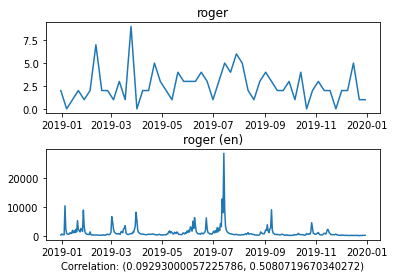

<Figure size 432x288 with 0 Axes>

In [16]:
w = words_analyze_shuffled[0]
w.ts_articles.timepoints = tp_ordered
graphics.createPDFwithBothPlots(w)

In [19]:
corr_shuffled = []
#Drop all timepoints which are not contained in both article and wikipedia timeseries
for w in words_analyze_shuffled:
    w_timepointsordered = copy.deepcopy(w)
    w_timepointsordered.ts_articles.timepoints = sorted(w_timepointsordered.ts_articles.timepoints, key=lambda x: x.date, reverse=False)

    ts_a, ts_w = timeseries.alignTimeseries(w_timepointsordered.ts_articles,w_timepointsordered.ts_wiki)
    if len(ts_w.getCounts())<2 or len(ts_a.getCounts())<2:
        words_analyze_shuffled.remove(w)
    else:
        corr_shuffled.append(statistics.getCorrelation(ts_a.getCounts(),ts_w.getCounts()))
    
    #graphics.createPDFwithBothPlots(w_timepointsordered)
print(numpy.mean(corr_shuffled))

NameError: name 'copy' is not defined

In [44]:
w_1 = words_analyze_original[0]
w_2 = [x for x in words_analyze_shuffled if x.keyword == w_1.keyword][0]

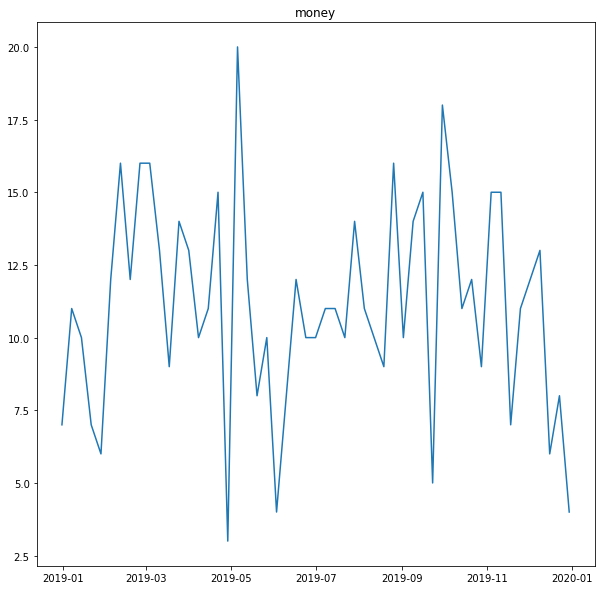

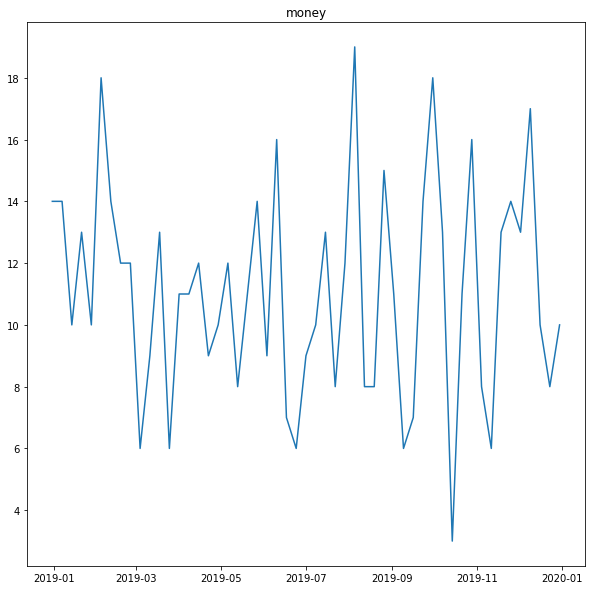

In [47]:
graphics.plot_dataset(w_1.keyword,w_1.ts_articles.getCounts(),w_1.ts_articles.getDates())
graphics.plot_dataset(w_2.keyword,w_2.ts_articles.getCounts(),sorted(w_2.ts_articles.getDates()))